# QC and filtering
<hr style="border:2px solid black"> </hr>

**Quality control**

"We must ensure that all cellular barcode data correspond to viable cells.

Cell QC is commonly performed based on three QC covariates: the number of counts per barcode (count depth), the number of genes per barcode, and the fraction of counts from mitochondrial genes per barcode.

The distributions of these QC covariates are examined for outlier peaks that are filtered out by thresholding.

These outlier barcodes can correspond to dying cells, cells whose membranes are broken, or doublets".

Samples with a low count depth, few detected genes, and a high fraction of mitochondrial counts are indicative of cells whose cytoplasmic mRNA has leaked out through a broken membrane.

In contrast, cells with unexpectedly high counts and a large number of detected genes may represent doublets.

**DOI: 10.15252/msb.20188746**

<hr style="border:2px solid black"> </hr>
<h1><center>⬐ Fill in input data here ⬎</center></h1>

In [1]:
#Set the species of the data
species = "mouse"

#Set the column in adata.obs containing the biological condition to evaluate
condition_column = "condition"

#Set the column in adata.var containing gene names
gene_column = "gene"

<hr style="border:2px solid black"> </hr>

## Loading packages and setup

In [2]:
#####################IMPORTING PACKAGES#############################
import sctoolbox
import sctoolbox.marker_genes as marker_genes
import sctoolbox.utilities as utils
import sctoolbox.analyser as analyser

from sctoolbox.checker import *
from sctoolbox.creators import *
from sctoolbox.qc_filter import *
from sctoolbox.plotting import *

## Loading the anndata setting the condition

In [3]:
adata = utils.load_anndata(is_from_previous_note=True, which_notebook=1, data_to_evaluate=condition_column)
display(adata)

AnnData object with n_obs × n_vars = 20192 × 55359
    obs: 'sample', 'condition', 'batch'
    var: 'gene', 'type'
    uns: 'color_set', 'infoprocess'
    layers: 'ambiguous', 'spliced', 'unspliced'

## Labelling genes

In [4]:
adata.uns["infoprocess"]["species"] = species

In [5]:
marker_genes.label_genes(adata, gene_column=gene_column)

display(adata.uns["infoprocess"]["genes_labeled"])

['is_ribo', 'is_mito', 'is_gender']

# D: Calculating QC metrics

In [6]:
#Calculating QC metrics
#If control_var=True, the anndata.var labeled genes you want to control the metrics calculation
adata = analyser.qcmetric_calculator(adata, control_var=True)

# E: Establishing the cutoffs for QC and filtering steps

**E1: DEFINING DEFAULT CUTOFFS FOR THE total_counts**

Low and high count depth indicates cells with low integrity and doublets, respectively (DOI: 10.15252/msb.20188746).

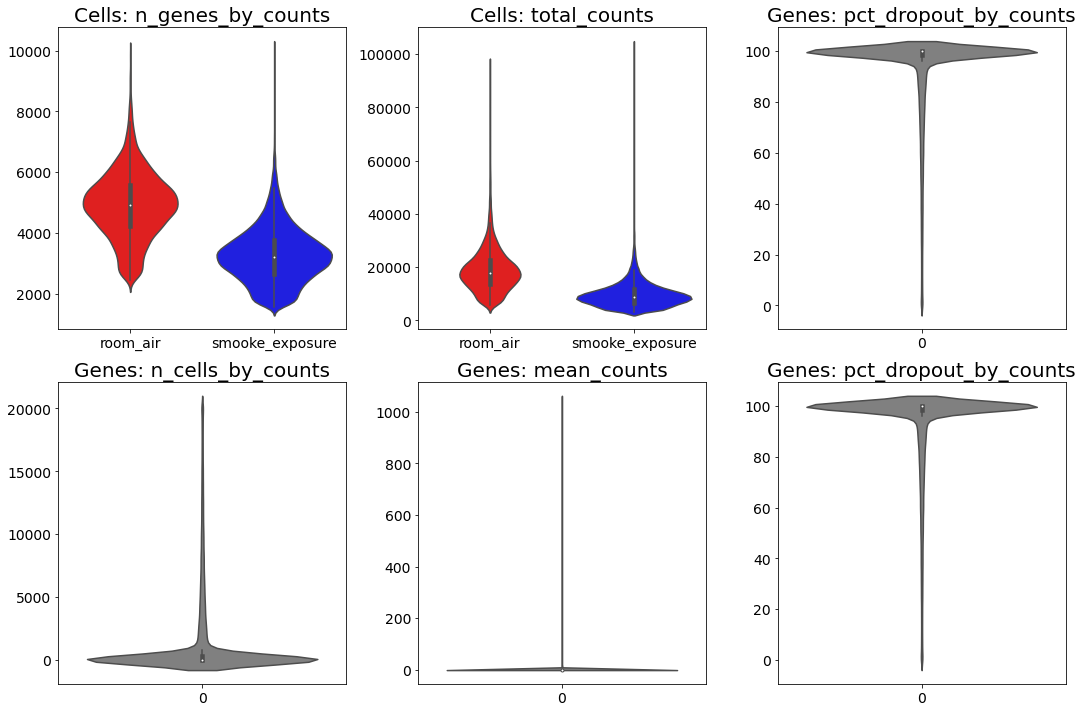

In [7]:
#Defining the default cutoffs for total_counts and ploting data
def_cut = set_def_cuts(adata, interval=0.95, save=True)

In [8]:
def_cut

,data_to_evaluate,parameters,cutoff,strategy


**E2: DEFINING CUSTOM CUTOFFS FOR total_counts**

In [9]:
#Refining cutoffs
go_cut = refining_cuts(adata, def_cut)
display(go_cut)

The default setting is:


,data_to_evaluate,parameters,cutoff,strategy




#########################################################
NOTE. Choose: 
	1) custom to define new cutoffs
	2) def to use the previously defined cutoffs
#########################################################



,data_to_evaluate,parameters,cutoff,strategy


In [10]:
go_cut

,data_to_evaluate,parameters,cutoff,strategy


**E3: FILTERING THE total_counts**

Low and high count depth indicates cells with low integrity and doublets, respectively (DOI: 10.15252/msb.20188746).

In [11]:
#Filtering the total counts
adata2 = anndata_filter(adata, go_cut)

IndexError: list index out of range

**E4: DEFINING DEFAULT CUTOFFS FOR THE OTHER PARAMETERS**

This step needs to be performed only after satisfatory total_counts filtering.

NOTE: use the adata2, because this is the object with the total_counts filtered

In [ ]:
#Defining the default cutoffs for all other parameters
def_cut = set_def_cuts(adata2, interval=0.95, save=True)

**E5: DEFINING CUSTOM CUTOFFS FOR ALL OTHER VARIABLES**

Here you need to use the adata3, because this is the one that had the total_counts already filtered

In [ ]:
#Refining cutoffs
go_cut = refining_cuts(adata2, def_cut)
display(go_cut)

**E6: FILTERING THE OTHER PARAMETERS**

In [ ]:
#Filtering other parameters
adata3 = anndata_filter(adata2, go_cut)

**E7: Remove ribosomal/mitochrondrial/gender genes/and others**

Optional

In [12]:
#remove mitochondrial
#adata4 = sctoolbox.qc_filter.filter_genes(adata3, "is_mitochondrial")
    
#remove cell cycle
#adata4 = sctoolbox.qc_filter.filter_genes(adata3, "is_cell_cycle")

#Remove gender genes
#adata4 = sctoolbox.qc_filter.filter_genes(adata3, "is_gender_genes")

#Remove custom genes from list
#adata4 = sctoolbox.qc_filter.filter_genes(adata3, "is_custom")

**E8: Final plotting**

You choose not plot cutoffs


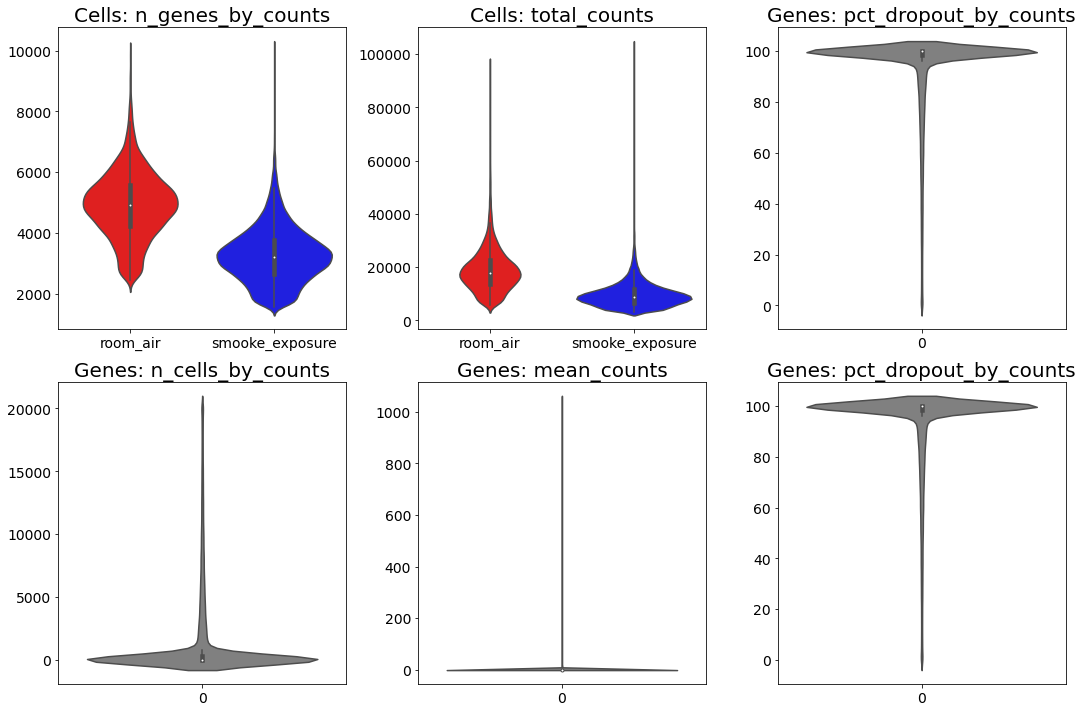

In [13]:
#Raw anndata
set_def_cuts(adata, only_plot=True, save=False)

In [14]:
#Filtered annadta
set_def_cuts(adata3, only_plot=True, save=False)

NameError: name 'adata3' is not defined

# F: Save the final adata

In [15]:
#Saving the anndata
#utils.saving_anndata(adata3, current_notebook=2)
utils.saving_anndata(adata, current_notebook=2) #hack to get to notebook 3

... storing 'cellcycle' as categorical


Your new anndata object is saved here: pipeline_output/results/Test1/anndata_2_Test1.h5ad
